# Documentation

Documentation of many LISA modules has got a big improvement with the usage of Sphinx and the refresh of docstrings for many existing methods.

You can access documentation either interactively in Notebooks, using the standard TAB completion after a function name, or by printing it in the Notebook itsels. For example:

In [1]:
from test import LisaTest

print LisaTest.__doc__


    A base class for LISA tests

    This class is intended to be subclassed in order to create automated tests
    for LISA. It sets up the TestEnv and Executor and provides convenience
    methods for making assertions on results.

    Subclasses should provide a test_conf to configure the TestEnv and an
    experiments_conf to configure the executor.

    Tests whose behaviour is dependent on target parameters, for example
    presence of cpufreq governors or number of CPUs, can override
    _getExperimentsConf to generate target-dependent experiments.

    Example users of this class can be found under LISA's tests/ directory.

    :ivar experiments: List of :class:`Experiment` s executed for the test. Only
                       available after :meth:`init` has been called.
    


# Energy Model Related APIs

The `EnergyModel` class has been added, which provides methods for describing platforms in order to estimate usage of CPU systems under various utilization scenario. The model is aware of frequency (DVFS) domains, power domains and idle states, as well as "cluster" energy.

Tests have been added that utulize the `EnergyModel` - see below for info about the Generic tests.

In [2]:
from energy_model import EnergyModel
print EnergyModel.__doc__

Represents hierarchical CPU topology with power and capacity data

    An energy model consists of

    - A CPU topology, representing the physical (cache/interconnect) topology of
      the CPUs.  Each node stores the energy usage of that node's hardware when
      it is in each active or idle state. They also store a compute capacity at
      each frequency, but this is only meaningful for leaf nodes (CPUs) and may
      be None at higher levels. These capacity values are relative; the maximum
      capacity would usually be 1024, the value of SCHED_CAPACITY_SCALE in the
      Linux kernel scheduler.  Use EnergyModelNodes to describe this.

    - A power domain topology, representing the hierarchy of areas that can be
      powered down (idled).
      The power domains are a single tree. Leaf nodes must contain exactly one
      CPU and the root node must indirectly contain every CPU. Each power domain
      has a list (maybe empty) of names of idle states that that domain can
      

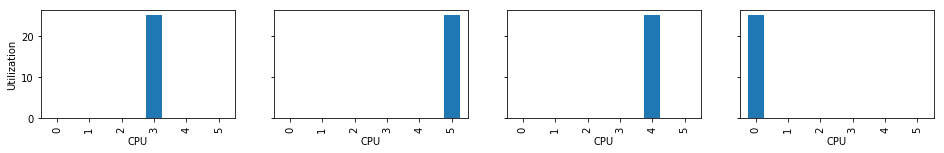

In [28]:
# juno_energy provides an instance of EnergyModel for ARM Juno platforms
from platforms.juno_energy import juno_energy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

possible_placements = juno_energy.get_optimal_placements({'task1': 10, 'task2': 15})
fig, axs = plt.subplots(1, 4, sharey=True)
# fig.set_ylabel('Utilization')
for ax, placement in zip(axs, possible_placements):
    ax.set_ylabel('Utilization')
    ax.set_xlabel('CPU')

    pd.DataFrame(list(placement)).plot(kind='bar', figsize=(16, 2), ax=ax, legend=False)

The above example shows how the `EnergyModel` class can be used to find optimal task placements. Here it is shown that on ARM Juno, if the system is presented with just two small tasks, it should place them on the same CPU, not using the big CPUs (1 and 2).

# Trace module

## Improved profiling analysis

The trace analysis module has got a more complete support for analysis of tasks properties.

Here is an example notebook which shows the new API in use on a relatively simple example:

https://gist.github.com/derkling/256256f47bc9daf4883f3cb6e356e26b

# Android Support

## API to run Android Workloads

A new API has been adde which allows to defined how to execute and Android workload with the additional support:
- to collect a trace across its execution
- to measure energy consumption across its execution 

In [4]:
from android import Workload

print Workload.__doc__


    Base class for Android related workloads
    


Public interface:

In [5]:
{ k:v for k,v in vars(Workload).items() if not k.startswith('_') }

{'getInstance': <classmethod at 0x7f9b5e1c5398>,
 'run': <function android.workload.run>,
 'tracingStart': <function android.workload.tracingStart>,
 'tracingStop': <function android.workload.tracingStop>}

The `run` method is the only one which the user is required to implement to specify how to run the specific Android workload.


To create a new workload it's required to create a new module under this folder:
`libs/utils/android/workloads`

Here is an enample of usage of this class to run a YouTube workload:

https://github.com/ARM-software/lisa/blob/master/libs/utils/android/workloads/youtube.py

## Android Workloads

Using the `Workload` class, some interesting Android workloads have been already integrated:

In [6]:
!tree $LISA_HOME/libs/utils/android/workloads

/home/brendan/sources/lisa/libs/utils/android/workloads
├── geekbench.py
├── geekbench.pyc
├── gmaps.py
├── gmaps.pyc
├── jankbench.py
├── jankbench.pyc
├── uibench.py
├── uibench.pyc
├── vellamo.py
├── vellamo.pyc
├── youtube.py
└── youtube.pyc

0 directories, 12 files


... and others are on their way ;-)

## API to run Android Tests

A new API has been added which allows to defined how to run an Android workload to perform a pre-defined set of experiments.

In [7]:
from android import LisaBenchmark

print LisaBenchmark.__doc__


    A base class for LISA custom benchmarks execution

    This class is intended to be subclassed in order to create a custom
    benckmark execution for LISA.
    It sets up the TestEnv and and provides convenience methods for
    test environment setup, execution and post-processing.

    Subclasses should provide a bm_conf to setup the TestEnv and
    a set of optional callback methods to configuere a test environment
    and process collected data.

    Example users of this class can be found under LISA's tests/benchmarks
    directory.
    


Public interface:

In [8]:
{ k:v for k,v in vars(LisaBenchmark).items() if not k.startswith('_') }

{'benchmarkFinalize': <function android.benchmark.benchmarkFinalize>,
 'benchmarkInit': <function android.benchmark.benchmarkInit>,
 'bm_collect': None,
 'bm_conf': None,
 'bm_name': None,
 'bm_params': None,
 'reboot_target': <function android.benchmark.reboot_target>}

To create a test the used need to define proper values for the `bm_*` attributes.

Optionally the `benchmarkInit` and `benchmarkFinalize` methods can also be defined.

Here is an example usage of this API to run a YouTube workload using different CPUFreq governor:

https://github.com/ARM-software/lisa/blob/master/tests/benchmarks/android_youtube.py

# Tests

The new test API and LISA support allows to run tests both in batch, useful for regression testing, as well as interactively on a Notebook. This last mode is partitularely useful to support both tests development as well as to do further interactive analysis based on test results. For example it makes more easy to investigate the reasons for a test failure.

## Generic EAS tests

https://github.com/ARM-software/lisa/pull/263

Provides a new full set of EAS behaviors testing based on EM data. These tests are designed to be completely generic and portable across different platform.

The `Run Generic Automated EAS tests` example notebook:

https://github.com/ARM-software/lisa/blob/master/ipynb/tests/Generic_EAS_Tests.ipynb

gives an example of using this test.

## Frequency Invariant Test

https://github.com/ARM-software/lisa/pull/254

The frequency invariance machinary is a the base of a proper functioning of the EAS.
We added a test which verifys frequency and cpu invarnace for load and utilization signals.

The `Frequency Invariant Load Tracking Test` example notebook:

https://github.com/ARM-software/lisa/blob/master/ipynb/tests/Frequency_Invariance_Test.ipynb

gives an example of using this test.